# **Setup**

## Import notebooks

In [1]:
%%capture
# Note the python import here
import reuse, sys

# This is the Ipython hook
sys.meta_path.append(reuse.NotebookFinder())
from dataset_balancing import X_train, X_test, y_train, y_test

## Import libraries

In [2]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Feature selection**

## Filter Method

### Variance Threshold

In [3]:
selector = VarianceThreshold()
selector.fit_transform(X_train)
selector.variances_

array([3.52729416e-01, 1.44055700e+06, 6.73852724e+00, 2.38703153e-01,
       2.24836271e-01, 1.08825049e-01, 1.95080065e-01, 9.99990000e+04,
       3.90000000e+03, 5.75279633e-01, 7.50358515e-02, 2.05433348e-01,
       1.28875976e-01, 3.32867282e-04, 1.17931456e-01, 2.49172327e-01,
       1.65654163e-01, 2.13662344e-02, 9.04472097e-02, 7.13395278e-02,
       5.80981246e-02])

### SelectKBest

The optimal k is 12 and the accuracy score is 0.7918326693227091


,Feature
0,age
1,education-num
2,marital-status
3,occupation
4,sex
5,capital-gain
6,capital-loss
7,hours-per-week
8,relationship_ Husband
9,relationship_ Not-in-family


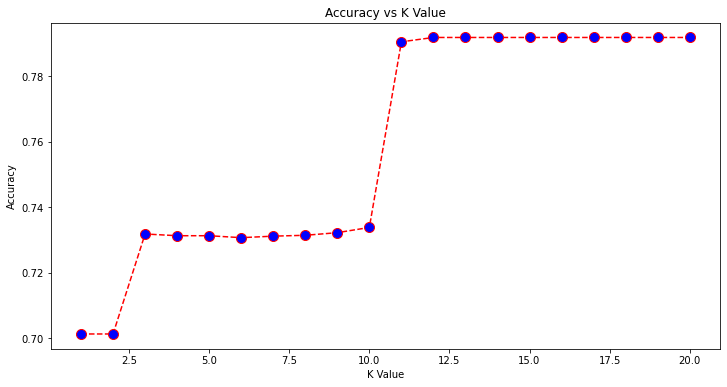

In [4]:
k_list = list(range(1, 21))

accuracy_scores = []

for k_value in k_list:
    selector = SelectKBest(f_classif, k=k_value)
    selector.fit(X_train, y_train)
    cols = selector.get_support(indices=True)
    cols_names = list(X_train.columns[cols])

    temp_train = X_train[cols_names]
    temp_test = X_test[cols_names]

    clf_model = SVC(random_state=0)

    clf_model.fit(temp_train,y_train)
    score = clf_model.score(temp_test,y_test)
    
    accuracy_scores.append(score)

optimal_k = k_list[accuracy_scores.index(max(accuracy_scores))]
print(f"The optimal k is {optimal_k} and the accuracy score is {max(accuracy_scores)}")

selector = SelectKBest(f_classif, k=optimal_k)
selector.fit(X_train, y_train)
cols = selector.get_support(indices=True)
cols_names = list(X_train.columns[cols])

tabela = pd.DataFrame({'Feature':cols_names})
tabela.to_latex(buf="tables/selectkbest.tex", caption="Características selecionadas pelo método \\textit{SelectKBest}", index=False)
display(tabela)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), accuracy_scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.savefig('images/other/selectkbest.png', dpi=200)

## Wrapper Method

### Recursive Feature Elimination

In [5]:
model = LogisticRegression(solver='lbfgs',max_iter=5000, random_state=0)
rfe = RFE(model,step=1)
rfe.fit(X_train,y_train)
print('Optimal number of features: {}'.format(rfe.n_features_))
cols = rfe.get_support(indices=True)
cols_names = list(X_train.columns[cols])
tabela = pd.DataFrame({'Feature':cols_names})
tabela.to_latex(buf="tables/rfe.tex", caption=("Características selecionadas pelo método \\textit{RFE}"), index=False)
tabela

Optimal number of features: 10


,Feature
0,age
1,marital-status
2,occupation
3,sex
4,hours-per-week
5,workclass_others
6,relationship_ Husband
7,relationship_ Other-relative
8,relationship_ Own-child
9,relationship_ Wife


## Embedded method

### Principal Component Analysis

Optimal number of components: 19


,Feature
0,age
1,fnlwgt
2,education-num
3,marital-status
4,occupation
5,race
6,sex
7,capital-gain
8,capital-loss
9,hours-per-week


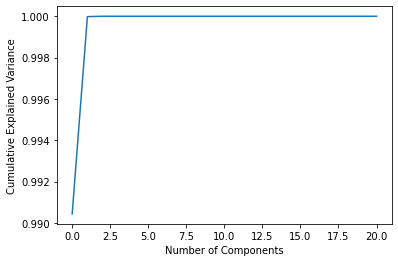

In [6]:
pca=PCA(random_state=0)
pca.fit(X_train)
cumulative_variances = np.cumsum(pca.explained_variance_ratio_)
maximum = max(cumulative_variances)
index_of_maximum = np.where(cumulative_variances == maximum)
print(f"Optimal number of components: {index_of_maximum[0][0]+1}")
tabela = pd.DataFrame({'Feature':X_train.columns[0:19]})
tabela.to_latex(buf="tables/pca.tex", caption=("Características selecionadas pelo método \\textit{PCA}"), index=False)
display(tabela)
plt.plot(cumulative_variances)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('images/other/pca.png', dpi=200)

### Feature Importance

In [7]:
model = ExtraTreesClassifier(n_estimators=21, random_state=0)
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
tabela = pd.DataFrame({'Feature':list(X_train.columns[indices]), 'Importance': importances[indices]})
tabela.to_latex(buf="tables/feature_importance.tex", caption=("Características selecionadas pelo método \\textit{Feature Importance}"), column_format='lr', index=False)
tabela

,Feature,Importance
0,fnlwgt,0.330851
1,education-num,0.115385
2,marital-status,0.097309
3,relationship_ Husband,0.065748
4,capital-gain,0.064775
5,occupation,0.064027
6,age,0.052612
7,hours-per-week,0.048835
8,relationship_ Not-in-family,0.030828
9,relationship_ Own-child,0.026898


## Drop irrelevant features

In [8]:
X_train = X_train.drop(['fnlwgt', 'relationship_ Not-in-family', 'workclass_selfempl'],1)
X_test = X_test.drop(['fnlwgt', 'relationship_ Not-in-family', 'workclass_selfempl'],1)